In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
import json
from collections import namedtuple
import re
import copy

import itertools
from pprint import pprint

# Functions

In [2]:
# Find files
# This function input the path of experiment directory and output a list of device directories of the experiment directory.
def find_device_under_exp(exp_dir_path):
    dev_dir_list = sorted([os.path.join(exp_dir_path, d) for d in os.listdir(exp_dir_path) if d.startswith('qc') or d.startswith('sm')])
    return dev_dir_list

def find_trace_under_device(dev_dir_path):
    trace_dir_list = sorted([os.path.join(dev_dir_path, d) for d in os.listdir(dev_dir_path)])
    return trace_dir_list


# Convenience instance
class EXPERIMENT():
    def __init__(self, exp_dir_path, settings):
        self.path = exp_dir_path
        self.settings = json.loads(settings)
    def __repr__(self):
        return f'EXP: {self.path} -> {self.settings}'

In [3]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


In [4]:
def loss_excl_cause(loss_lat_file_path, rrc_file_path):

    loss_lat_df = pd.read_csv(loss_lat_file_path)

    loss_cond = loss_lat_df['lost'] == True
    loss_packets = loss_lat_df[loss_cond]
    loss_packets = loss_packets.reset_index(drop=True)
    loss_packets['Timestamp'] = pd.to_datetime(loss_packets['Timestamp'])

    exc_lat = 0.1
    excl_cond = (loss_cond==False) & (loss_lat_df['latency'] > exc_lat)
    excl_packets = loss_lat_df[excl_cond]
    excl_packets = excl_packets.reset_index(drop=True)
    excl_packets['Timestamp'] = pd.to_datetime(excl_packets['Timestamp'])

    HO_dict = parse_mi_ho(rrc_file_path)
    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    LOSS_PKT = namedtuple('LOSS_PKT',['timestamp', 'seq', 'cause', 'trans', 'trans_time', 'others'], defaults=['', 0, [], [], [], []])

    LOSS_PKTs = []

    for i in range(len(loss_packets)):

        loss_packet = loss_packets.iloc[i]
        loss_packet_timestamp = loss_packet['Timestamp']
        seq = loss_packet['seq']
        
        cause = []
        trans = []
        others = []
        trans_time = []

        for HO_type, slot in zip(events, slots):
            
            HOs = HO_dict[HO_type]  

            for h in HOs:
                
                if h.start - slot < loss_packet_timestamp < h.start:
                    cause.append(f'Before {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.start)
                    others.append(h.others)
                elif (h.end is not None) and (h.start < loss_packet_timestamp < h.end):
                    cause.append(f'During {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append((h.start, h.end))
                    others.append(h.others)
                elif (h.end is not None) and (h.end < loss_packet_timestamp < h.end + slot):
                    cause.append(f'After {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.end)
                    others.append(h.others)

        LOSS_PKTs.append(LOSS_PKT(timestamp=loss_packet_timestamp, seq=seq, cause=cause, others=others))
                
    EXCL_PKT = namedtuple('EXCL_PKT',['timestamp', 'seq', 'cause', 'trans', 'trans_time', 'others'], defaults=['', 0, [], [], [], []])

    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1)]
    
    EXCL_PKTs = []

    for i in range(len(excl_packets)):

        excl_packet = excl_packets.iloc[i]
        excl_packet_timestamp = excl_packet['Timestamp']
        seq = excl_packet['seq']

        cause = []
        trans = []
        trans_time = []
        others = []

        for HO_type, slot in zip(events, slots):
            
            HOs = HO_dict[HO_type]   
            for h in HOs:
                
                if h.start - slot < excl_packet_timestamp < h.start:
                    cause.append(f'Before {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.start)
                    others.append(h.others)
                elif (h.end is not None) and (h.start < excl_packet_timestamp < h.end):
                    cause.append(f'During {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append((h.start, h.end))
                    others.append(h.others)
                elif (h.end is not None) and (h.end < excl_packet_timestamp < h.end + slot):
                    cause.append(f'After {HO_type}') 
                    trans.append(h.trans)
                    trans_time.append(h.end)
                    others.append(h.others)

        EXCL_PKTs.append(EXCL_PKT(timestamp=excl_packet_timestamp, seq=seq, cause=cause, trans=trans, trans_time=trans_time, others=others))
    
    return LOSS_PKTs, EXCL_PKTs

#

def loss_excl_cause_dual(loss_lat_file_path1, loss_lat_file_path2, rrc_file_path1, rrc_file_path2):

    df1 = pd.read_csv(loss_lat_file_path1)
    df2 = pd.read_csv(loss_lat_file_path2)

    start_seq = df1['seq'].iloc[0] if df1['seq'].iloc[0] >=  df2['seq'].iloc[0] else df2['seq'].iloc[0]
    end_seq = df1['seq'].iloc[-1] if df1['seq'].iloc[-1] <=  df2['seq'].iloc[-1] else df2['seq'].iloc[-1]

    cond1 = (df1['seq'] >= start_seq) & (df1['seq'] <= end_seq)
    df1 = df1[cond1]
    df1 = df1.reset_index(drop=True)
    cond2 = (df2['seq'] >= start_seq) & (df2['seq'] <= end_seq)
    df2 = df2[cond2]
    df2 = df2.reset_index(drop=True)

    # Loss calculate for dual radios redundant packets.
    loss_cond = (df1['lost'] == True) & (df2['lost'] == True)

    loss_packets1 = df1[loss_cond]
    loss_packets1 = loss_packets1.reset_index(drop=True)
    loss_packets1['Timestamp'] = pd.to_datetime(loss_packets1['Timestamp'])

    loss_packets2 = df2[loss_cond]
    loss_packets2 = loss_packets2.reset_index(drop=True)
    loss_packets2['Timestamp'] = pd.to_datetime(loss_packets2['Timestamp'])

    # Excexxive latency calculate for dual radios redundant packets.
    exc_lat = 0.1 
    excl_cond1 = (loss_cond==False) & (df1['latency'] > exc_lat)
    excl_cond2 = (loss_cond==False) & (df2['latency'] > exc_lat)
    excl_cond = (excl_cond1 == True) & (excl_cond2 == True)
    
    excl_packets1 = df1[excl_cond]
    excl_packets1 = excl_packets1.reset_index(drop=True)
    excl_packets1['Timestamp'] = pd.to_datetime(excl_packets1['Timestamp'])

    excl_packets2 = df2[excl_cond]
    excl_packets2 = excl_packets2.reset_index(drop=True)
    excl_packets2['Timestamp'] = pd.to_datetime(excl_packets2['Timestamp'])

    HO_dict1 = parse_mi_ho(rrc_file_path1)
    HO_dict2 = parse_mi_ho(rrc_file_path2)
    
    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    LOSS_PKT_DUAL = namedtuple('LOSS_PKT_DUAL',
                               ['timestamp1', 'timestamp2', 'seq', 'cause1', 'cause2', 'trans1', 'trans2', 'others1', 'others2','trans1_time', 'trans2_time'], 
                               defaults=['', '', 0, [], [], [], [], [], [], [], []])

    LOSS_PKT_DUALs = []

    for i in range(len(loss_packets1)):

        loss_packet1 = loss_packets1.iloc[i]
        loss_packet1_timestamp = loss_packet1['Timestamp']

        loss_packet2 = loss_packets2.iloc[i]
        loss_packet2_timestamp = loss_packet2['Timestamp']

        seq = loss_packet1['seq']
        
        cause1, cause2 = [], []
        trans1, trans2 = [], []
        others1, others2 = [], []
        trans1_time, trans2_time = [], []

        for HO_type, slot in zip(events, slots):
            
            HOs1 = HO_dict1[HO_type]
            HOs2 = HO_dict2[HO_type]   

            for h in HOs1:
                
                if h.start - slot < loss_packet1_timestamp < h.start:
                    cause1.append(f'Before {HO_type}') 
                    trans1.append(h.trans)
                    trans1_time.append(h.start)
                    others1.append(h.others)

                elif (h.end is not None) and (h.start < loss_packet1_timestamp < h.end):
                    cause1.append(f'During {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append((h.start, h.end))
                    others1.append(h.others)

                elif (h.end is not None) and (h.end < loss_packet1_timestamp < h.end + slot):
                    cause1.append(f'After {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append(h.end)
                    others1.append(h.others)
            
            for h in HOs2:
                
                if h.start - slot < loss_packet2_timestamp < h.start:
                    cause2.append(f'Before {HO_type}') 
                    trans2.append(h.trans)
                    trans2_time.append(h.start)
                    others2.append(h.others)

                elif (h.end is not None) and (h.start < loss_packet2_timestamp < h.end):
                    cause2.append(f'During {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append((h.start, h.end))
                    others2.append(h.others)

                elif (h.end is not None) and (h.end < loss_packet2_timestamp < h.end + slot):
                    cause2.append(f'After {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append(h.end)
                    others2.append(h.others)
    
        LOSS_PKT_DUALs.append(LOSS_PKT_DUAL(timestamp1=loss_packet1_timestamp, timestamp2=loss_packet2_timestamp, seq=seq, 
        cause1=cause1, cause2=cause2, trans1=trans1, trans2=trans2, others1=others1, others2=others2, trans1_time=trans1_time, trans2_time=trans2_time))
                
    slot = dt.timedelta(seconds=2)
    EXCL_PKT_DUAL = namedtuple('EXCL_PKT_DUAL',
                               ['timestamp1', 'timestamp2', 'seq', 'cause1', 'cause2', 'trans1', 'trans2', 'others1', 'others2','trans1_time', 'trans2_time'], 
                               defaults=['', '', 0, [], [], [], [], [], [], [], []])

    events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 
              'SN_Rel', 'SN_HO', 'RLF_II', 'RLF_III', 'SCG_RLF',
              'Conn_Req']
    slots = [dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=1),
             dt.timedelta(seconds=1), dt.timedelta(seconds=1), dt.timedelta(seconds=2), dt.timedelta(seconds=2), dt.timedelta(seconds=2),
             dt.timedelta(seconds=1)]
    
    
    EXCL_PKT_DUALs = []

    for i in range(len(excl_packets1)):

        excl_packet1 = excl_packets1.iloc[i]
        excl_packet1_timestamp = excl_packet1['Timestamp']
        excl_packet2 = excl_packets2.iloc[i]
        excl_packet2_timestamp = excl_packet2['Timestamp']

        seq = excl_packet1['seq']

        cause1, cause2 = [], []
        trans1, trans2 = [], []
        others1, others2 = [], []
        trans1_time, trans2_time = [], []

        for HO_type, slot in zip(events, slots):
            
            HOs1 = HO_dict1[HO_type]
            HOs2 = HO_dict2[HO_type]

            for h in HOs1:
                
                if h.start - slot < excl_packet1_timestamp < h.start:
                    cause1.append(f'Before {HO_type}') 
                    trans1.append(h.trans)
                    trans1_time.append(h.start)
                    others1.append(h.others)

                elif (h.end is not None) and (h.start < excl_packet1_timestamp < h.end):
                    cause1.append(f'During {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append((h.start, h.end))
                    others1.append(h.others)

                elif (h.end is not None) and (h.end < excl_packet1_timestamp < h.end + slot):
                    cause1.append(f'After {HO_type}')
                    trans1.append(h.trans)
                    trans1_time.append(h.end)
                    others1.append(h.others)

            for h in HOs2:
                
                if h.start - slot < excl_packet2_timestamp < h.start:
                    cause2.append(f'Before {HO_type}') 
                    trans2.append(h.trans)
                    trans2_time.append(h.start)
                    others2.append(h.others)

                elif (h.end is not None) and (h.start < excl_packet2_timestamp < h.end):
                    cause2.append(f'During {HO_type}')
                    trans2.append(h.trans)
                    trans2_time.append((h.start, h.end))
                    others2.append(h.others)

                elif (h.end is not None) and (h.end < excl_packet2_timestamp < h.end + slot):
                    cause2.append(f'After {HO_type}')
                    trans2.append(h.trans)                   
                    trans2_time.append(h.end)
                    others2.append(h.others)

        EXCL_PKT_DUALs.append(EXCL_PKT_DUAL(timestamp1=excl_packet1_timestamp, timestamp2=excl_packet2_timestamp, seq=seq, 
        cause1=cause1, cause2=cause2, trans1=trans1, trans2=trans2, others1=others1, others2=others2, trans1_time=trans1_time, trans2_time=trans2_time))

    return LOSS_PKT_DUALs, EXCL_PKT_DUALs

In [5]:
# Analyse every case.
EVENTS = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 
          'SN_setup', 'SN_Rel', 'SN_HO', 
          'RLF_II', 'RLF_III', 'SCG_RLF']

REs = [r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| O', 
       r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| (\d+)', 
       r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| (\d+) -> O',
       r'\((\d+), (\d+)\) \| O -> (\d+)', 
       r'\((\d+), (\d+)\) \| (\d+) -> O', 
       r'\((\d+), (\d+)\) \| (\d+) -> (\d+)',
       r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| (\d+) -> O', 
       r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| (\d+) -> O',
       r'\((\d+), (\d+)\) \| (\d+) -> O']

def get_re_from_type(event):
    if event in EVENTS:
        index = EVENTS.index(event)
        return REs[index]
    else:
        return None
    
EVENTS1 = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB']

CASES = ['all', 'two_event', 'one_event'] + \
        ['two_RLF', 'two_scg_failure', 'one_RLF_one_scg', 'one_RLF', 'one_scg_failure'] + \
        ['two_exact_identicle_HO'] + [f'two_exact_identicle_{type}' for type in EVENTS] + \
        ['two_identicle_RLF_SN_setup'] + \
        ['pci_earfcn_identicle_HO_eNB'] + [f'pci_earfcn_identicle_{type}' for type in EVENTS1] + \
        ['pci_identicle_HO_eNB'] + [f'pci_identicle_{type}' for type in EVENTS1] + \
        ['pci_identicle_HO_gNB'] + \
        ['pci_earfcn_identicle_RLF'] + ['pci_identicle_RLF'] + ['pci_identicle_sRLF'] + \
        ['pci_identicle_RLF_setup_cause_pci', 'pci_identicle_RLF_setup_cause_pci_earfcn'] + \
        ['SN_setup_of_RLF_MN_HO_to_eNB', 'SN_setup_of_RLF_SN_Rel', 'SN_setup_of_MN_HO_to_eNB_SN_Rel'] + \
        ['SN_setup_same_cause_rlf_pci', 'SN_setup_same_cause_rlf_pci_earfcn'] + \
        ['SN_setup_of_same_cause_MN_HO_to_eNB', 'SN_setup_of_same_cause_SN_Rel', 'SN_setup_same_cause_rlf']

ANALYSIS = namedtuple('ANALYSIS', CASES, defaults = [0]*len(CASES))

def Analyze(pkgs):
    
    # Useful functions.
    # 
    def remove_elements(A, B, condition):
        indexes_to_remove = [i for i, a in enumerate(A) if condition(a)]
        for index in sorted(indexes_to_remove, reverse=True):
            del A[index]
            del B[index]
        return A, B
    
    # Case functions.
    # Case source and target cause type, trans are exactly the same.
    # A is cause list and B is trans list. 
    # Totally identical in trans string.
    def find_exact_identicle(A1, B1, A2, B2):

        L = []
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]

        for i, (a1, b1) in enumerate(zip(A1_, B1)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2)):
                if a1 == a2 and b1 == b2:
                    L.append((i, j))
                    
        return L
    
    # Case source and target cause type, trans "pci" and "earfcn" are the same.
    # A is cause list and B is trans list.
    # This case only deal with ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'].
    def find_pci_earfcn_identicle(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'({match.group(1)}, {match.group(2)}) -> ({match.group(3)}, {match.group(4)})'
            else:
                return None
            
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in EVENTS1)
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in EVENTS1)
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if b1 == b2:
                    L.append((i, j))

        return L

    # Case source and target cause type, trans "pci" are exactly the same.
    # A is cause list and B is trans list.
    # This case only deal with ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'].
    def find_pci_identicle(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'{match.group(1)} -> {match.group(3)}'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in EVENTS1)
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in EVENTS1)
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if b1 == b2:
                    L.append((i, j))

        return L
    
    # Case source and target cause type, trans "pci" are exactly the same.
    # A is cause list and B is trans list.
    # This case only deal with 'gNB_HO.
    def find_pci_identicle_gNB(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'({match.group(3)}, {match.group(4)})'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['SN_HO'])
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in ['SN_HO'])
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if a1 == a2 and b1 == b2:
                    L.append((i, j))

        return L
    
    # Case source and target cause type, trans source "pci" and "earfcn" are exactly the same.
    # A is cause list and B is trans list.
    # This case only deal with ['RLF_II'] now.
    def find_pci_earfcn_identicle_RLF(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'({match.group(1)}, {match.group(2)})'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['RLF_II'])
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in ['RLF_II'])
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if a1 == a2 and b1 == b2:
                    L.append((i, j))

        return L
    
    # Case source and target cause type, trans source "pci" are exactly the same.
    # A is cause list and B is trans list.
    # This case only deal with ['RLF_II'] now.
    def find_pci_identicle_RLF(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'{match.group(1)}'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['RLF_II'])
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in ['RLF_II'])
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if a1 == a2 and b1 == b2:
                    L.append((i, j))

        return L
    
    # This case checks whether a loss/excl dual packet with 
    # cause1 of RLF and cause2 of SN_setup has the same origin 
    # of rlf cell.
    def find_RLF_SN_Setup_Same_Cause_pci(A1, B1, A2, C2):

        L = []

        def extract_coordinates(input_string, event, seq):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'{match.group(seq)}'
            else:
                return None
        
        def extract_coordinates2(input_string, pattern, seq):

            match = re.search(pattern, input_string)
            
            if match:
                return f'{match.group(seq)}'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; C2_ = [element for element in C2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['RLF_II', 'RLF_III'])
        A2_, C2_ = remove_elements(A2_, C2_, lambda a: a not in ['SN_setup'])
        B1_ = [extract_coordinates(b1, a1, 1) for b1, a1 in zip(B1_, A1_)]
        C2_ = [extract_coordinates2(c2, r'\((\d+), (\d+)\)', 1) for c2 in C2_]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, c2) in enumerate(zip(A2_, C2_)):                
                if a1 == a2 and b1 == c2:
                    L.append((i, j))

        return L

    # This case checks whether a loss/excl dual packet with 
    # cause1 of RLF and cause2 of SN_setup has the same origin 
    # of rlf cell.
    def find_RLF_SN_Setup_Same_Cause_pci_earfcn(A1, B1, A2, C2):

        L = []

        def extract_coordinates(input_string, event, seq):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'({match.group(seq[0])}, {match.group(seq[1])})'
            else:
                return None
        
        def extract_coordinates2(input_string, pattern, seq):

            match = re.search(pattern, input_string)
            
            if match:
                return f'({match.group(seq[0])}, {match.group(seq[1])})'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; C2_ = [element for element in C2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['RLF_II', 'RLF_III'])
        A2_, C2_ = remove_elements(A2_, C2_, lambda a: a not in ['SN_setup'])
        B1_ = [extract_coordinates(b1, a1, [1, 2]) for b1, a1 in zip(B1_, A1_)]
        C2_ = [extract_coordinates2(c2, r'\((\d+), (\d+)\)', [1, 2]) for c2 in C2_]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, c2) in enumerate(zip(A2_, C2_)):                
                if a1 == a2 and b1 == c2:
                    L.append((i, j))

        return L

    # This case checks whether a loss/excl dual packet with 
    # cause1 of RLF and cause2 of SN_setup has the same origin 
    # of rlf cell.
    def find_SN_Setup_Same_Cause_pci_earfcn(A1, C1, A2, C2):

        L = []
        
        def extract_coordinates(input_string, pattern, seq):

            match = re.search(pattern, input_string)
            
            if match:
                return f'({match.group(seq[0])}, {match.group(seq[1])})'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; C1_ = [element for element in C1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; C2_ = [element for element in C2]
        A1_, C1_ = remove_elements(A1_, C1_, lambda a: a not in ['SN_setup'])
        A2_, C2_ = remove_elements(A2_, C2_, lambda a: a not in ['SN_setup'])
        C1_ = [extract_coordinates(c1, r'\((\d+), (\d+)\)', [1, 2]) for c1 in C1_]
        C2_ = [extract_coordinates(c2, r'\((\d+), (\d+)\)', [1, 2]) for c2 in C2_]

        for i, (a1, c1) in enumerate(zip(A1_, C1_)):    
            for j, (a2, c2) in enumerate(zip(A2_, C2_)):                
                if a1 == a2 and c1 == c2:
                    L.append((i, j))

        return L


    # This case checks whether a loss/excl dual packet with 
    # cause1 of RLF and cause2 of SN_setup has the same origin 
    # of rlf cell.
    def find_SN_Setup_Same_Cause_pci(A1, C1, A2, C2):

        L = []
        
        def extract_coordinates(input_string, pattern, seq):

            match = re.search(pattern, input_string)
            
            if match:
                return f'{match.group(seq[0])}'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; C1_ = [element for element in C1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; C2_ = [element for element in C2]
        A1_, C1_ = remove_elements(A1_, C1_, lambda a: a not in ['SN_setup'])
        A2_, C2_ = remove_elements(A2_, C2_, lambda a: a not in ['SN_setup'])
        C1_ = [extract_coordinates(c1, r'\((\d+), (\d+)\)', [1]) for c1 in C1_]
        C2_ = [extract_coordinates(c2, r'\((\d+), (\d+)\)', [1]) for c2 in C2_]

        for i, (a1, c1) in enumerate(zip(A1_, C1_)):    
            for j, (a2, c2) in enumerate(zip(A2_, C2_)):                
                if a1 == a2 and c1 == c2:
                    L.append((i, j))

        return L


    # Case source and target cause type, trans source "pci" are exactly the same.
    # A is cause list and B is trans list.
    # This case only deal with 'SCG_RLF' now.
    def find_pci_identicle_sRLF(A1, B1, A2, B2):

        L = []

        def extract_coordinates(input_string, event):
            pattern = get_re_from_type(event)
            match = re.match(pattern, input_string)
            
            if match:
                return f'{match.group(3)}'
            else:
                return None
        
        # Take out before, during, and after prefix.
        A1_ = [a1.split(' ')[-1] for a1 in A1]; B1_ = [element for element in B1]
        A2_ = [a2.split(' ')[-1] for a2 in A2]; B2_ = [element for element in B2]
        A1_, B1_ = remove_elements(A1_, B1_, lambda a: a not in ['SCG_RLF'])
        A2_, B2_ = remove_elements(A2_, B2_, lambda a: a not in ['SCG_RLF'])
        B1_ = [extract_coordinates(b1, a1) for b1, a1 in zip(B1_, A1_)]
        B2_ = [extract_coordinates(b2, a2) for b2, a2 in zip(B2_, A2_)]

        for i, (a1, b1) in enumerate(zip(A1_, B1_)):    
            for j, (a2, b2) in enumerate(zip(A2_, B2_)):                
                if a1 == a2 and b1 == b2:
                    L.append((i, j))

        return L

    # Count the number of every case. 
    nums = {k: 0 for k in CASES}
    nums['all'] = len(pkgs)

    for pkg in pkgs:
        
        cause1_string = "".join(pkg.cause1)
        cause2_string = "".join(pkg.cause2)
        others1_string = "".join(pkg.others1)
        others2_string = "".join(pkg.others2)

        # Event related check.
        if cause1_string and cause2_string:
            nums['two_event'] += 1
        elif cause1_string or cause2_string:
            nums['one_event'] += 1

        # RLF related case.
        if ('RLF_' in cause1_string) and ('RLF_' in cause2_string):   
            nums['two_RLF'] += 1

            # Nested Events
            l1 = find_pci_identicle_RLF(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2)
            if len(l1) != 0: 
                nums['pci_identicle_RLF'] += 1
                
                l2 = find_pci_earfcn_identicle_RLF(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2)
                if len(l2) != 0:
                    nums['pci_earfcn_identicle_RLF'] += 1

        elif ('RLF_' in cause1_string) and ('SN_setup' in cause2_string and 'Near after RLF' in others2_string):

            l1 = find_RLF_SN_Setup_Same_Cause_pci(pkg.cause1, pkg.trans1, pkg.cause2, pkg.others2)
            if len(l1) != 0:
                nums['pci_identicle_RLF_setup_cause_pci'] += 1

                l2 = find_RLF_SN_Setup_Same_Cause_pci_earfcn(pkg.cause1, pkg.trans1, pkg.cause2, pkg.others2)
                if len(l1) != 0:
                    nums['pci_identicle_RLF_setup_cause_pci_earfcn'] += 1

        elif ('SN_setup' in cause1_string and 'Near after RLF' in others1_string) and ('RLF_' in cause2_string):

            l1 = find_RLF_SN_Setup_Same_Cause_pci(pkg.cause2, pkg.trans2, pkg.cause1, pkg.others1)
            if len(l1) != 0:
                nums['pci_identicle_RLF_setup_cause_pci'] += 1

                l2 = find_RLF_SN_Setup_Same_Cause_pci_earfcn(pkg.cause2, pkg.trans2, pkg.cause1, pkg.others1)
                if len(l1) != 0:
                    nums['pci_identicle_RLF_setup_cause_pci_earfcn'] += 1

        elif ('RLF_' in cause1_string) or ('RLF_' in cause2_string):  
            nums['one_RLF'] += 1

        # elif ('SCG_RLF' in cause1_string) and ('SCG_RLF' in cause2_string): 
        #     nums['two_scg_failure'] += 1
        
        # elif (('RLF_' in cause1_string) and ('SCG_RLF' in cause2_string) ) or (('SCG_RLF' in cause1_string) and ('RLF_' in cause2_string) ):
        #     nums['one_RLF_one_scg'] += 1

        # elif ('SCG_RLF' in cause1_string) or ('SCG_RLF' in cause2_string): 
        #     nums['one_scg_failure'] += 1

        # elif ('RLF_' in cause1_string) or ('RLF_' in cause2_string):  
        #     nums['one_RLF'] += 1

        # SN setup case observation.
        if ('SN_setup' in cause1_string) and ('SN_setup' in cause2_string):
            
            p = r' Near after (.*?)\.'
            
            try: match1 = re.search(p, others1_string); s1 = match1.group(1)
            except: s1 = 'Unknown'

            try: match2 = re.search(p, others2_string); s2 = match2.group(1)
            except: s2 = 'Unknown'

            if ('RLF' in s1) and ('RLF' in s2):
                
                nums['SN_setup_same_cause_rlf'] += 1

                l1 = find_SN_Setup_Same_Cause_pci(pkg.cause1, pkg.others1, pkg.cause2, pkg.others2)
                if len(l1) != 0:
                    nums['SN_setup_same_cause_rlf_pci'] += 1

                    l2 = find_SN_Setup_Same_Cause_pci_earfcn(pkg.cause1, pkg.others1, pkg.cause2, pkg.others2)
                    if len(l2) != 0:
                        nums['SN_setup_same_cause_rlf_pci_earfcn'] += 1

            elif ('MN_HO_to_eNB' in s1) and ('MN_HO_to_eNB' in s2):
                nums['SN_setup_of_same_cause_MN_HO_to_eNB'] += 1
            elif ('SN_Rel' in s1) and ('SN_Rel' in s2):
                nums['SN_setup_of_same_cause_SN_Rel'] += 1
            elif ('RLF' in s1 or 'RLF' in s2) and ('MN_HO_to_eNB' in s1 or 'MN_HO_to_eNB' in s2):
                nums['SN_setup_of_RLF_MN_HO_to_eNB'] += 1
            elif ('RLF' in s1 or 'RLF' in s2) and ('SN_Rel' in s1 or 'SN_Rel' in s2):
                nums['SN_setup_of_RLF_SN_Rel'] += 1
            elif ('MN_HO_to_eNB' in s1 or 'MN_HO_to_eNB' in s2) and ('SN_Rel' in s1 or 'SN_Rel' in s2):
                nums['SN_setup_of_MN_HO_to_eNB_SN_Rel'] += 1

        # Identicle HO related case.
        # Case Exact Identicle.
        L1 = find_exact_identicle(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2)
        if len(L1) != 0: nums['two_exact_identicle_HO'] += 1
        
        identicle_types = []
        for (i, _) in L1:
            _, ho_type = pkg.cause1[i].split(' ')
            identicle_types.append(ho_type)
            nums[f'two_exact_identicle_{ho_type}'] += 1

        if ('RLF_II' in identicle_types or 'RLF_III' in identicle_types) and ('SN_setup' in identicle_types):
            nums[f'two_identicle_RLF_SN_setup'] += 1

        # eNB HO related
        L2 = find_pci_identicle(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2) 
        
        if len(L2) != 0: 
            nums['pci_identicle_HO_eNB'] += 1

            l1 = find_pci_earfcn_identicle(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2) 
            if len(l1) != 0: 
                nums['pci_earfcn_identicle_HO_eNB'] += 1

        # gNB related
        L3 = find_pci_identicle_gNB(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2) 
        if len(L3) != 0: nums['pci_identicle_HO_gNB'] += 1

        # srlf related cases.
        L4 = find_pci_identicle_sRLF(pkg.cause1, pkg.trans1, pkg.cause2, pkg.trans2) 
        if len(L4) != 0: nums['pci_identicle_sRLF'] += 1

    return ANALYSIS(*nums.values())

# Main

In [6]:
# This place give a XXXX-XX-XX.md file and find the experiment directory path
# and the corresponding band settings. It will be presented by a list of special
# instance EXPERIMENTs.
md_files = ['/home/wmnlab/D/database/2023-08-29/2023-08-29.md', 
            '/home/wmnlab/D/database/2023-09-12_1/2023-09-12.md',
            '/home/wmnlab/D/database/2023-09-22/2023-09-22.md',
            '/home/wmnlab/D/database/2023-10-24/2023-10-24.md']
EXPs = []

for md_file_path in md_files:

    date_dir_path = os.path.dirname(md_file_path)

    with open(md_file_path) as f:

        exp = f.readline()[:-1]
        settings = f.readline()[:-1]

        while exp != '#endif' and settings:
            E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
            EXPs.append(E)
            exp = f.readline()[:-1]
            settings = f.readline()[:-1]

pprint(EXPs)

[EXP: /home/wmnlab/D/database/2023-08-29/Modem_Action_Test -> {'qc00': 'test', 'qc03': 'test'},
 EXP: /home/wmnlab/D/database/2023-08-29/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-12_1/Modem_Action_Test -> {'qc00': 'test', 'qc03': 'test'},
 EXP: /home/wmnlab/D/database/2023-09-12_1/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-22/Modem_Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Modem_Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Modem_Control_Group3 -> {'qc00': 'B1B3', 'qc03': 'B7B8'}]


# Single Radio Analysis

In [ ]:
# This code evaluate the nearby event of a packet loss/ excl packet of a single radio performance.

# Record
keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']
cases = ANALYSIS._fields
analysis_dict_all = {}
for k in keys:
    analysis_dict_all[k] = {case: 0 for case in cases}

analysis_dicts = []
corresponding_list = []

# Some settings
keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']
count_events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 
          'SN_setup', 'SN_Rel', 'SN_HO', 
          'RLF_II', 'RLF_III', 'SCG_RLF', 'Conn_Req']
bdr = ['Before', 'During', 'After']

comb = itertools.product(bdr, count_events)
count_bdr_events = [t+' '+ho for t, ho in comb]

analysis_dicts = []
corresponding_list = []

# Record how many total packet.
total_Modem_Action_Test = {k:0 for k in keys}
total_Modem_Control_Group = {k:0 for k in keys}
total_Modem_Control_Group2 = {k:0 for k in keys}
total_Modem_Control_Group3 = {k:0 for k in keys}

for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]

    # Below can be used to filtering.
    # if name != 'Modem_Action_Test':
    #     continue

    for dev_dir_path in dev_dir_list:
        
        dev = dev_dir_path.split('/')[-1]
        trace_dir_list = find_trace_under_device(dev_dir_path)

        for trace_dir_path in trace_dir_list:

            trace = trace_dir_path.split('/')[-1]
            print(date, name, dev, trace)
            corresponding_list.append((date, name, dev, trace))

            data_dir_path = os.path.join(trace_dir_path, 'data')
            rrc_file = [p for p in os.listdir(data_dir_path) if p.endswith('_rrc.csv')][0]
            rrc_file_path = os.path.join(data_dir_path, rrc_file)
            dl_file_path = os.path.join(data_dir_path, 'udp_dnlk_loss_latency.csv')
            ul_file_path = os.path.join(data_dir_path, 'udp_uplk_loss_latency.csv')

            dl_loss_pkgs, dl_excl_pkgs  = loss_excl_cause(dl_file_path, rrc_file_path)
            ul_loss_pkgs, ul_excl_pkgs = loss_excl_cause(ul_file_path, rrc_file_path)
        
            # Count total number
            counts = [len(dl_loss_pkgs), len(dl_excl_pkgs), len(ul_loss_pkgs), len(ul_excl_pkgs)]

            for k, num in zip(keys, counts):
                if name == 'Modem_Action_Test':
                    total_Modem_Action_Test[k] += num
                elif name == 'Modem_Control_Group':
                    total_Modem_Control_Group[k] += num
                elif name == 'Modem_Control_Group2':
                    total_Modem_Control_Group2[k] += num
                elif name == 'Modem_Control_Group3':
                    total_Modem_Control_Group3[k] += num
                    
            # Count event caused number
            analysis_dict = {}

            for pkgs, k in zip([dl_loss_pkgs, dl_excl_pkgs, ul_loss_pkgs, ul_excl_pkgs], keys):
                
                d = {e: 0 for e in count_bdr_events}
                
                for pkg in pkgs:
                    for possible_cause, other in zip(pkg.cause, pkg.others):
                        
                        for count_e in count_bdr_events:                            
                            if count_e == possible_cause:

                                # This Conn_Req should be count in RLF III end.
                                if ('Conn_Req' in count_e) and ('After RLF III.' in other):
                                    continue

                                d[count_e] += 1
            
                analysis_dict[k] = d
            
            analysis_dicts.append(analysis_dict)

# corresponding_list

In [ ]:
action_group = {}
control_group = {} # All + All
control_group2 = {} # All + LTE
control_group3 = {} # Lock Band+Lock Band

for k in keys:
    action_group[k] = {case: 0 for case in count_bdr_events}
    control_group[k] = {case: 0 for case in count_bdr_events}
    control_group2[k] = {case: 0 for case in count_bdr_events}
    control_group3[k] = {case: 0 for case in count_bdr_events}

for analysis_dict, info in zip(analysis_dicts, corresponding_list):

    name, dev = info[1], info[3]
    
    for k, d in analysis_dict.items():

        for kk, v in d.items():

            if name == 'Modem_Action_Test':
                action_group[k][kk] += v
            elif name == 'Modem_Control_Group':
                control_group[k][kk] += v
            elif name == 'Modem_Control_Group2':
                control_group2[k][kk] += v
            elif name == 'Modem_Control_Group3':
                control_group3[k][kk] += v
        

In [ ]:
# corresponding_list

In [ ]:
# analysis_dicts

In [ ]:
# action_group

In [ ]:
# Change Here
group = control_group
total = total_Modem_Control_Group

fig, axes = plt.subplots(2,2, figsize=(12, 8))

metric_categories = []
metric_values = []

for k in keys:
    
    target = group[k]
    total_num = total[k]

    categories = []
    values = []

    for e in count_events:
        num = 0
        for t in bdr:
            num += target[t+' '+e]
        categories.append(e)
        values.append(num/total_num)

    metric_categories.append(categories)
    metric_values.append(values)

# Change Conn_req to Change_Band
for categories in metric_categories:
    idx = categories.index('Conn_Req')
    categories[idx] = 'Change_Band'

titles = ['DL Loss', 'DL Excessive Latency', 'Ul Loss', 'UL Excessive Latency']
for i, ax in enumerate(axes.flatten()):

    x = np.arange(len(metric_categories[i]))
    ax.bar(x, metric_values[i], width=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_categories[i], rotation=45)
    ax.set_title(titles[i])

    # For not see change band.
    ax.set_xlim([0-0.6,9-0.6])


# plt.xticks(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Change Here
group = control_group
total = total_Modem_Control_Group

fig, axes = plt.subplots(2,2, figsize=(12, 8))

metric_categories = []
metric_values = []

for k in keys:
    
    target = group[k]
    total_num = total[k]
    
    categories = []
    values = []

    for e in count_events:
        
        v_split = []
        for t in bdr:
            num = target[t+' '+e]
            v_split.append(num/total_num)
        categories.append(e)
        values.append(v_split)

    metric_categories.append(categories)
    metric_values.append(values)

# Change Conn_req to Change_Band
for categories in metric_categories:
    idx = categories.index('Conn_Req')
    categories[idx] = 'Change_Band'

titles = ['DL Loss', 'DL Excessive Latency', 'Ul Loss', 'UL Excessive Latency']
for i, ax in enumerate(axes.flatten()):
    
    x1 = [j-0.25 for j in range(len(metric_categories[i]))]
    x2 = [j for j in range(len(metric_categories[i]))]
    x3 = [j+0.25 for j in range(len(metric_categories[i]))]

    v1 = [x[0] for x in metric_values[i]]
    v2 = [x[1] for x in metric_values[i]]
    v3 = [x[2] for x in metric_values[i]]

    ax.bar(x1, v1, width=0.25)
    ax.bar(x2, v2, width=0.25)
    ax.bar(x3, v3, width=0.25)
    ax.set_xticks(x2)
    ax.set_xticklabels(metric_categories[i], rotation=45)
    ax.set_title(titles[i])
    ax.legend(bdr)

    # For not see change band.
    ax.set_xlim([0-0.6,9-0.6])


# plt.xticks(fontsize=8)

plt.tight_layout()
plt.show()

# Dual Radio Analysis

In [7]:
# This code counts the number of occurrences for each special case for dual radio transmission.
# Still need to revise here.

# Record
keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']
cases = ANALYSIS._fields
analysis_dict_all = {}
for k in keys:
    analysis_dict_all[k] = {case: 0 for case in cases}

# # Some settings
# count_events = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 
#           'SN_setup', 'SN_Rel', 'SN_HO', 
#           'RLF_II', 'RLF_III', 'SCG_RLF', 'Conn_Req']
# bdr = ['Before', 'During', 'After']

# comb = itertools.product(bdr, count_events)
# count_events = [t+' '+ho for t, ho in comb]

analysis_dicts = []
analysis_dicts2 = []
corresponding_list = []

# Record how many total packet.
total_Modem_Action_Test = {k:0 for k in keys}
total_Modem_Control_Group = {k:0 for k in keys}
total_Modem_Control_Group2 = {k:0 for k in keys}
total_Modem_Control_Group3 = {k:0 for k in keys}


for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    comb = itertools.combinations(dev_dir_list, 2)
    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]
    
    for dev_dir_path1, dev_dir_path2 in comb:
        
        dev1 = dev_dir_path1.split('/')[-1]
        dev2 = dev_dir_path2.split('/')[-1]
        
        trace_dir_list1 = find_trace_under_device(dev_dir_path1)
        trace_dir_list2 = find_trace_under_device(dev_dir_path2)

        for trace_dir_path1, trace_dir_path2 in zip(trace_dir_list1, trace_dir_list2):

            trace = trace_dir_path1.split('/')[-1]
            print(date, name, trace, dev1, dev2)

            data_dir_path1 = os.path.join(trace_dir_path1, 'data')
            rrc_file1 = [p for p in os.listdir(data_dir_path1) if p.endswith('_rrc.csv')][0]
            rrc_file_path1 = os.path.join(data_dir_path1, rrc_file1)
            dl_file_path1 = os.path.join(data_dir_path1, 'udp_dnlk_loss_latency.csv')
            ul_file_path1 = os.path.join(data_dir_path1, 'udp_uplk_loss_latency.csv')

            data_dir_path2 = os.path.join(trace_dir_path2, 'data')
            rrc_file2 = [p for p in os.listdir(data_dir_path2) if p.endswith('_rrc.csv')][0]
            rrc_file_path2 = os.path.join(data_dir_path2, rrc_file2)
            dl_file_path2 = os.path.join(data_dir_path2, 'udp_dnlk_loss_latency.csv')
            ul_file_path2 = os.path.join(data_dir_path2, 'udp_uplk_loss_latency.csv')

            dl_loss_pkgs, dl_excl_pkgs  = loss_excl_cause_dual(dl_file_path1, dl_file_path2, rrc_file_path1, rrc_file_path2)
            ul_loss_pkgs, ul_excl_pkgs = loss_excl_cause_dual(ul_file_path1, ul_file_path2, rrc_file_path1, rrc_file_path2)

            # Special case analysis.
            values = [Analyze(dl_loss_pkgs), Analyze(dl_excl_pkgs), Analyze(ul_loss_pkgs), Analyze(ul_excl_pkgs)]
            analysis_dict = {k: v for k, v in zip(keys, values)}
            
            # Count total number
            counts = [len(dl_loss_pkgs), len(dl_excl_pkgs), len(ul_loss_pkgs), len(ul_excl_pkgs)]

            for k, num in zip(keys, counts):
                if name == 'Modem_Action_Test':
                    total_Modem_Action_Test[k] += num
                elif name == 'Modem_Control_Group':
                    total_Modem_Control_Group[k] += num
                elif name == 'Modem_Control_Group2':
                    total_Modem_Control_Group2[k] += num
                elif name == 'Modem_Control_Group3':
                    total_Modem_Control_Group3[k] += num

            # Count caused event combinations.
            analysis_dict2 = {}

            for pkgs, k in zip([dl_loss_pkgs, dl_excl_pkgs, ul_loss_pkgs, ul_excl_pkgs], keys):
                
                d = {}
                
                for pkg in pkgs:

                    cause1 = [c.split(' ')[-1] for c in pkg.cause1]
                    cause2 = [c.split(' ')[-1] for c in pkg.cause2]

                    def remove_duplicates(lst):
                        return list(set(lst))

                    cause1 = remove_duplicates(cause1)
                    cause2 = remove_duplicates(cause2)
                    counted = []

                    for c1, o1 in zip(cause1, pkg.others1):
                        if (c1 == 'Conn_Req') and ('After RLF III.' in o1):
                            print('working')
                            continue
                        
                        for c2, o2 in zip(cause2, pkg.others2):
                            if (c2 == 'Conn_Req') and ('After RLF III.' in o2):
                                print('working')
                                continue
                            
                            new_k = ' | '.join(sorted([c1,c2]))

                            if new_k  in d.keys() and new_k not in counted:
                                d[new_k] += 1
                                counted.append(new_k)
                            else:
                                d[new_k] = 1
                                counted.append(new_k)
            
                analysis_dict2[k] = d
            
            analysis_dicts2.append(analysis_dict2)

            for k in keys:
                for i, case in enumerate(cases):
                    analysis_dict_all[k][case] += analysis_dict[k][i]
            
            analysis_dicts.append(analysis_dict)
            corresponding_list.append((date, name, trace, dev1, dev2))

2023-08-29 Modem_Action_Test #01 qc00 qc03
2023-08-29 Modem_Action_Test #02 qc00 qc03
2023-08-29 Modem_Action_Test #03 qc00 qc03
2023-08-29 Modem_Action_Test #04 qc00 qc03
2023-08-29 Modem_Control_Group #01 qc00 qc03
2023-08-29 Modem_Control_Group #02 qc00 qc03
2023-08-29 Modem_Control_Group #03 qc00 qc03
2023-08-29 Modem_Control_Group #04 qc00 qc03
2023-08-29 Modem_Control_Group #05 qc00 qc03
2023-08-29 Modem_Control_Group #06 qc00 qc03
2023-09-12_1 Modem_Action_Test #01 qc00 qc03
2023-09-12_1 Modem_Action_Test #02 qc00 qc03
2023-09-12_1 Modem_Action_Test #03 qc00 qc03
2023-09-12_1 Modem_Action_Test #04 qc00 qc03
2023-09-12_1 Modem_Action_Test #05 qc00 qc03
2023-09-12_1 Modem_Control_Group #01 qc00 qc03
2023-09-12_1 Modem_Control_Group #02 qc00 qc03
2023-09-12_1 Modem_Control_Group #03 qc00 qc03
2023-09-12_1 Modem_Control_Group #04 qc00 qc03
2023-09-22 Modem_Control_Group2 #01 qc00 qc03
2023-09-22 Modem_Control_Group2 #02 qc00 qc03
2023-09-22 Modem_Control_Group2 #03 qc00 qc03
2023-09

In [8]:
action_group = {}
control_group = {}
control_group2 = {}
control_group3 = {}


keys = ['dl_loss', 'dl_excl', 'ul_loss', 'ul_excl']
for k in keys:
    action_group[k] = {}
    control_group[k] = {}
    control_group2[k] = {}
    control_group3[k] = {}

for d2, info in zip(analysis_dicts2, corresponding_list):

    name = info[1]

    for k in keys:

        target = d2[k]
        
        for event_comb, v in target.items():

            if name == 'Modem_Action_Test':
                
                if event_comb in action_group[k].keys():
                    action_group[k][event_comb] += v
                else:
                    action_group[k][event_comb] = v

            elif name == 'Modem_Control_Group':
                
                if event_comb in control_group[k].keys():
                    control_group[k][event_comb] += v
                else:
                    control_group[k][event_comb] = v
            
            elif name == 'Modem_Control_Group2':
                
                if event_comb in control_group2[k].keys():
                    control_group2[k][event_comb] += v
                else:
                    control_group2[k][event_comb] = v

            elif name == 'Modem_Control_Group3':
                
                if event_comb in control_group3[k].keys():
                    control_group3[k][event_comb] += v
                else:
                    control_group3[k][event_comb] = v

#  test, c1, c2
# 9, 10, 6

In [16]:
# control_group3

In [12]:
target_group = control_group3
total = total_Modem_Control_Group3

for k in keys:
    
    data = target_group[k]
    num = total[k]

    sorted_items = sorted(data.items(), key=lambda x: -x[1])
    sorted_items = [(a, round(b/num, 2)) for (a, b) in sorted_items]
    # sorted_items = sorted_items[:10]
    
    break

In [13]:
sorted_items # DL

[('SN_setup | SN_setup', 1.0),
 ('RLF_II | RLF_II', 0.84),
 ('MN_HO_to_eNB | RLF_II', 0.58),
 ('MN_HO_to_eNB | SN_setup', 0.58),
 ('MN_HO | RLF_II', 0.26),
 ('MN_HO | SN_setup', 0.26),
 ('RLF_II | SN_setup', 0.17)]

In [ ]:
# control_group, total_Modem_Control_Group

In [ ]:
# control_group2, total_Modem_Control_Group2

In [ ]:
# action_group, total_Modem_Action_Test

In [ ]:
keys_to_remove = ['two_scg_failure', 'one_RLF_one_scg', 'one_scg_failure'] + \
                ['pci_earfcn_identicle_LTE_HO', 'pci_earfcn_identicle_MN_HO', 'pci_earfcn_identicle_MN_HO_to_eNB'] + \
                ['pci_identicle_LTE_HO', 'pci_identicle_MN_HO', 'pci_identicle_MN_HO_to_eNB']

for inner_dict in analysis_dict_all.values():
    for key in keys_to_remove:
        inner_dict.pop(key, None)

# Some Plot

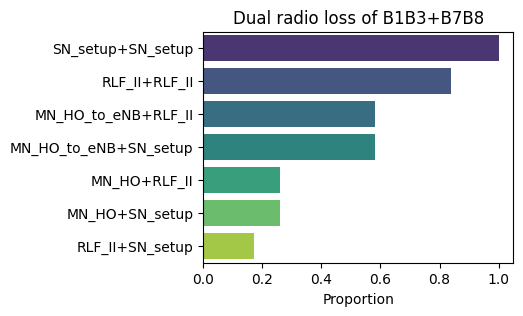

In [18]:
# Data
T = 'Dual radio loss of B1B3+B7B8' # Title
categories = [x[0].replace(' | ','+') for x in sorted_items]
values = [x[1] for x in sorted_items]

# 使用Seaborn绘制横条图
plt.figure(figsize=(4,3))
sns.barplot(x=values, y=categories, palette='viridis')  # 使用barplot函数绘制横条图，设置颜色主题为'viridis'
plt.xlabel('Proportion')  # x轴标签
plt.title(T)  # 图表标题
plt.show()